# LAB 6: Text classification with linear models

Objectives:
- Train and evaluate linear text classifiers using SGDClassifier
- Experiment with different feature extraction and training methods
- Some things to try:
  - [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn-linear-model-sgdclassifier)
  - [TFIDFVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn-feature-extraction-text-tfidfvectorizer)
  - [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn-decomposition-truncatedsvd)

In [1]:
# loss parameters
# tfidf diff ways of building tdm
# extracting relavent data
# accuracy % correct out of all
# goal increase micro avg-arith mean of all f1 scores

In [2]:
import nltk
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

## Load and pre-process data

CCAT : CORPORATE/INDUSTRIAL  
ECAT : ECONOMICS  
GCAT : GOVERNMENT/SOCIAL  
MCAT : MARKETS 

In [3]:
train = pd.read_pickle("/data/rcv1-topics-train.pkl")
test = pd.read_pickle("/data/rcv1-topics-test.pkl")
test.head()
# sample of articles labels in 1 of 4

,text,topics
0,Ecuador's Government Minister quits. Ecuador's...,GCAT
1,"SAfrica Old Mutual, Portugal bank in joint ven...",CCAT
2,"Lipper general muni fund index 128.00, down 0....",MCAT
3,U.S. resource use level not sustainable - S.F....,ECAT
4,General Instrument aims to unlock value. Gener...,CCAT


In [4]:
train["topics"].value_counts()

CCAT    5896
MCAT    3281
GCAT    3225
ECAT    1073
Name: topics, dtype: int64

In [5]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)


def tokenize(text):
    doc = nlp.tokenizer(text)
    return " ".join(t.norm_ for t in doc if t.is_alpha)

In [6]:
train["tokens"] = train["text"].progress_apply(tokenize)
test["tokens"] = test["text"].progress_apply(tokenize)

  0%|          | 0/13475 [00:00<?, ?it/s]

  0%|          | 0/3369 [00:00<?, ?it/s]

In [7]:
train['tokens'].iloc[0]
# numbers punctuations gone
# the is there

'nz bonds close well bid ahead of key data at figures in brackets compare against previous day close futures physical yield pct day bills jun prev days prev yr bonds jun prev prev yr bonds jun prev prev overnight cash pct prev us yr prev nzd usd prev us yr prev twi prev us yr prev nz mci vs vs nz monetary conditions remain loose at the close economists warn of reserve bank action key data tonight may cause yields to rise rumors of possible million global kiwi issue new zealand monetary conditions remained very loose at the debt market close on friday as bank bills refused to rise in response to a sharply lower dollar trade weighted index economists warned that the reserve bank was close to taking action to counter the market led easing of the past hours the monetary conditions index mci stood more than basis points equivalent below the rbnz desired line but dealers said key non farm payrolls data due out tonight could prompt the sell off required to bring conditions back within the cen

-------

## MultinomialNB

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [9]:
mnb = make_pipeline(CountVectorizer(token_pattern=r"\S+"), MultinomialNB())# sequence of non spaces
mnb.fit(train["tokens"], train["topics"])
predicted = mnb.predict(test["tokens"])
print(classification_report(test["topics"], predicted))

              precision    recall  f1-score   support

        CCAT       0.96      0.94      0.95      1475
        ECAT       0.92      0.65      0.76       268
        GCAT       0.93      0.98      0.95       806
        MCAT       0.90      0.97      0.94       820

    accuracy                           0.93      3369
   macro avg       0.93      0.88      0.90      3369
weighted avg       0.94      0.93      0.93      3369



In [10]:
# macro avg
# 
from scipy.stats.distributions import loguniform, randint, uniform
from sklearn.model_selection import RandomizedSearchCV

HYPERPARAMETER SEARCH

In [11]:
search = RandomizedSearchCV(
    mnb,
    {
        "countvectorizer__min_df": randint(1, 10),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "multinomialnb__alpha": loguniform(1e-8, 1.0),
    },
    n_iter=10,
    n_jobs=-1,
    scoring="f1_macro",
)

search.fit(train["tokens"], train["topics"])

RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(token_pattern='\\S+')),
                                             ('multinomialnb',
                                              MultinomialNB())]),
                   n_jobs=-1,
                   param_distributions={'countvectorizer__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2b3631ef3e80>,
                                        'countvectorizer__min_df': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2b3624ce77c0>,
                                        'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2b3632339d80>},
                   scoring='f1_macro')

In [12]:
mnb.set_params(**search.best_params_)
mnb.fit(train["tokens"], train["topics"])
predicted = mnb.predict(test["tokens"])
print(classification_report(test["topics"], predicted))
# macro avg 92 now

              precision    recall  f1-score   support

        CCAT       0.97      0.95      0.96      1475
        ECAT       0.92      0.74      0.82       268
        GCAT       0.92      0.98      0.95       806
        MCAT       0.92      0.97      0.95       820

    accuracy                           0.94      3369
   macro avg       0.93      0.91      0.92      3369
weighted avg       0.94      0.94      0.94      3369



-------

## SGDClassifier

In [13]:
from sklearn.linear_model import SGDClassifier

In [14]:
sgd = make_pipeline(CountVectorizer(token_pattern=r"\S+"), SGDClassifier())
sgd.fit(train["tokens"], train["topics"])
predicted = sgd.predict(test["tokens"])
print(classification_report(test["topics"], predicted))
# 94 macro

              precision    recall  f1-score   support

        CCAT       0.97      0.96      0.97      1475
        ECAT       0.90      0.87      0.89       268
        GCAT       0.96      0.98      0.97       806
        MCAT       0.95      0.96      0.96       820

    accuracy                           0.96      3369
   macro avg       0.95      0.94      0.94      3369
weighted avg       0.96      0.96      0.96      3369



### Hyperparameter search

In [15]:
search = RandomizedSearchCV(
    sgd,
    {
        "sgdclassifier__alpha": loguniform(1e-8, 1.0),
    },
    n_iter=5,
    n_jobs=-1,
    scoring="f1_macro",
)

search.fit(train["tokens"], train["topics"])
# without n grams

RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(token_pattern='\\S+')),
                                             ('sgdclassifier',
                                              SGDClassifier())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'sgdclassifier__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2b3632338310>},
                   scoring='f1_macro')

<Axes: xlabel='param_sgdclassifier__alpha', ylabel='mean_test_score'>

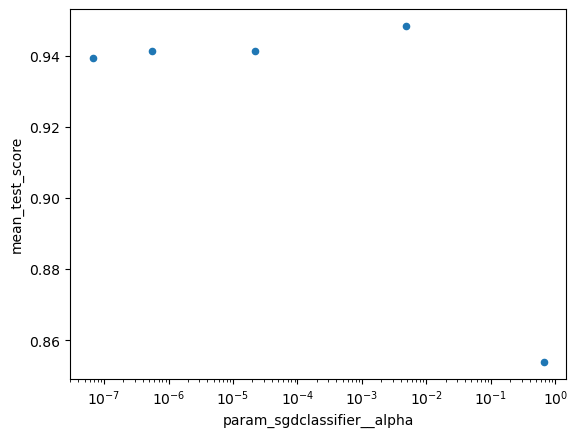

In [16]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.plot(
    "param_sgdclassifier__alpha", "mean_test_score", kind="scatter", logx=True
)

In [17]:
# good values are at 0.947

In [18]:
search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__ngram_range": [(1, 2)],# setting n gram range 1, 2 word 
        "sgdclassifier__alpha": loguniform(1e-8, 1.0),
    },
    n_iter=5,
    n_jobs=-1,
    scoring="f1_macro",
)

search.fit(train["tokens"], train["topics"])

RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(token_pattern='\\S+')),
                                             ('sgdclassifier',
                                              SGDClassifier())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'countvectorizer__ngram_range': [(1,
                                                                          2)],
                                        'sgdclassifier__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2b364503c850>},
                   scoring='f1_macro')

<Axes: xlabel='param_sgdclassifier__alpha', ylabel='mean_test_score'>

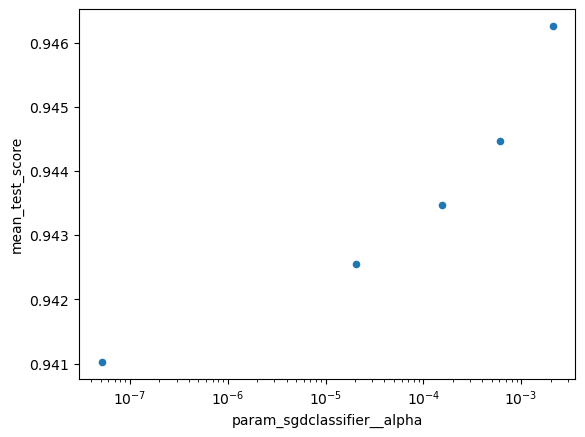

In [19]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.plot(
    "param_sgdclassifier__alpha", "mean_test_score", kind="scatter", logx=True
)

### Optimized model

In [20]:
sgd.set_params(countvectorizer__ngram_range=(1, 2), sgdclassifier__alpha=(1e-2))
sgd.fit(train["tokens"], train["topics"])
predicted = sgd.predict(test["tokens"])
print(classification_report(test["topics"], predicted))

              precision    recall  f1-score   support

        CCAT       0.98      0.96      0.97      1475
        ECAT       0.91      0.88      0.90       268
        GCAT       0.96      0.98      0.97       806
        MCAT       0.95      0.97      0.96       820

    accuracy                           0.96      3369
   macro avg       0.95      0.95      0.95      3369
weighted avg       0.96      0.96      0.96      3369



**SGD Classifier using Tfidf Vectorizer and Truncated SVD**

In [27]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
sgd2 = make_pipeline(TfidfVectorizer(token_pattern=r"\S+"),TruncatedSVD(250, n_iter=30), SGDClassifier())
sgd2.fit(train["tokens"], train["topics"])
sgd_predicted = sgd2.predict(test["tokens"])
print(classification_report(test["topics"], sgd_predicted))

              precision    recall  f1-score   support

        CCAT       0.96      0.96      0.96      1475
        ECAT       0.92      0.80      0.86       268
        GCAT       0.94      0.98      0.96       806
        MCAT       0.94      0.96      0.95       820

    accuracy                           0.95      3369
   macro avg       0.94      0.92      0.93      3369
weighted avg       0.95      0.95      0.95      3369



**Hyper Parameter Search**

In [29]:
search = RandomizedSearchCV(
    sgd2,
    {
        "sgdclassifier__alpha": loguniform(1e-8, 1.0),
    },
    n_iter=5,
    n_jobs=-1,
    scoring="f1_macro",
)

search.fit(train["tokens"], train["topics"])

RandomizedSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                              TfidfVectorizer(token_pattern='\\S+')),
                                             ('truncatedsvd',
                                              TruncatedSVD(n_components=250,
                                                           n_iter=30)),
                                             ('sgdclassifier',
                                              SGDClassifier())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'sgdclassifier__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x2b364ff650c0>},
                   scoring='f1_macro')

<Axes: xlabel='param_sgdclassifier__alpha', ylabel='mean_test_score'>

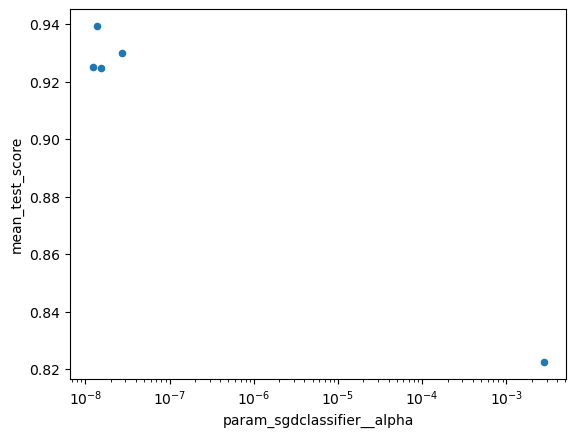

In [30]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.plot(
    "param_sgdclassifier__alpha", "mean_test_score", kind="scatter", logx=True
)

In [31]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_sgdclassifier__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,193.869378,3.729620,1.223805,0.094408,0.002778,{'sgdclassifier__alpha': 0.0027776176686138327},0.819394,0.827578,0.828892,0.804149,0.832034,0.822409,0.010039,5
1,159.436806,34.146658,0.861222,0.213212,0.0,{'sgdclassifier__alpha': 1.2288008593227042e-08},0.931453,0.933560,0.945548,0.902618,0.912120,0.925060,0.015518,3
2,119.845157,1.878941,0.908093,0.227774,0.0,{'sgdclassifier__alpha': 1.5392328236584493e-08},0.921425,0.932850,0.920331,0.928881,0.920264,0.924750,0.005165,4
3,98.072893,9.654914,0.704863,0.169259,0.0,{'sgdclassifier__alpha': 1.3855847499533094e-08},0.941854,0.935055,0.944538,0.935643,0.939121,0.939242,0.003616,1
4,82.543834,21.691830,0.638430,0.310949,0.0,{'sgdclassifier__alpha': 2.7215326051423348e-08},0.940624,0.933699,0.931136,0.910097,0.933759,0.929863,0.010373,2


In [32]:
search.best_params_, search.best_score_

({'sgdclassifier__alpha': 1.3855847499533094e-08}, 0.9392422049648312)

In [ ]:
search = RandomizedSearchCV(
    sgd2,
    {
        "sgdclassifier__alpha": loguniform(1e-8, 1e-4),
        "tfidfvectorizer__min_df": randint(0, 10),
        "tfidfvectorizer__max_df": uniform(0.5, 0.5),
        "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (2, 2)],
        "truncatedsvd__n_components": [1, 10, 50, 100, 200, 300]
    },
    n_iter=25,
    n_jobs=-1,
    scoring="f1_macro",
)

search.fit(train["tokens"], train["topics"])

In [ ]:
search.best_params_, search.best_score_

In [ ]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.plot(
    "param_sgdclassifier__alpha", "mean_test_score", kind="scatter", logx=True
)

In [ ]:
cv_results.head(5)

**Optimized model**

In [ ]:
sgd2.set_params(**search.best_params_))
sgd2.fit(train["tokens"], train["topics"])
sgd_tfidf_predicted = sgd2.predict(test["tokens"])
print(classification_report(test["topics"], sgd_tfidf_predicted))